#**DETECTING FAKE NEWS**

Detecting fake news from real news is a critical task in today’s digital age, where misinformation spreads quickly across online platforms. The importance lies in protecting the public from false or misleading information that can influence opinions, fuel conflicts, or cause harm in areas like politics, health, and finance. Natural Language Processing (NLP) plays a key role in this effort by enabling the automatic analysis of text to uncover patterns, sentiment, and linguistic cues that distinguish fake content from credible reporting. Through NLP, large volumes of news articles can be efficiently examined, helping to build systems that support fact-checking, media monitoring, and trustworthy information sharing.

In [ ]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings('ignore')
import string

**Loading dataset**

In [ ]:
#Importing dats using google link

missing_vals = ['unknown', '-', ' ']

import requests

def read_gd(sharing_url):
  """ Download a CSV file from Google Drive and returna Pandas DataFrame"""
  file_id = sharing_url.split('/')[-2] #Extracting file ID
  download_url = f"https://drive.google.com/uc?export=download&id=" + file_id

  url = requests.get(download_url).text
  csv_raw = StringIO(url)
  return csv_raw

url = "https://drive.google.com/file/d/1m1gRCISgJr0W2TiveQxCxOyw6G9Yiwkj/view?usp=sharing" #Data where burnout will be predicted

gdd = read_gd(url)

df = pd.read_csv(gdd, na_values = missing_vals)


df.head() # For predition after the model has been created

Unnamed: 0                                              title  \
0        8476                     You Can Smell Hillary‚Äôs Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  ‚Äî Kaydee King (@KaydeeKing) November 9, 2016...  FAKE  
4  It's primary day in New York and front-runners...  REAL

##**Data Overview**

In [ ]:
df.shape

(6335, 4)

The data set contains 6335 rows and 4 columns showing the title of the article, and the content of the article, and the label whether it is fake or real

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6299 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


**Checking for missing values**

In [ ]:
df.isnull().sum() #Checking number of missing values in each column

Unnamed: 0     0
title          0
text          36
label          0
dtype: int64

Since the number of missing values is less than 1% in the dataset. We will drop the missing values. it will not have any effect in the reult of our dataset

In [ ]:
df.dropna(inplace = True) #Drop missing values

df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [ ]:
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True) #Drop the first column

df.head()

title  \
0                     You Can Smell Hillary‚Äôs Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  ‚Äî Kaydee King (@KaydeeKing) November 9, 2016...  FAKE  
4  It's primary day in New York and front-runners...  REAL

label
REAL    3171
FAKE    3128
Name: count, dtype: int64


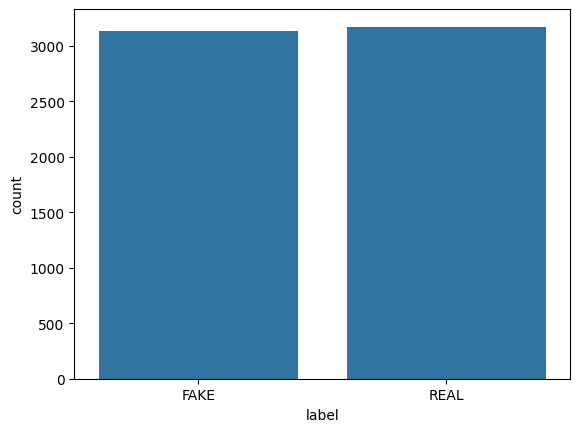

In [ ]:
vc = df['label'].value_counts()
sns.countplot(data=df, x='label')

print(vc)
plt.show()

In the dataset, there are 3,171 real news articles and 3,128 fake news articles. This shows that the data is almost perfectly balanced between the two classes, with only a small difference in counts. A balanced distribution like this is highly valuable for analysis and model training because it reduces the risk of bias toward one class, allowing the model to learn distinguishing features of both fake and real news more effectively.

##**Extracting Domain Sources**

Since I only have the titles and text without URLs, I will use a regex search combined with a keyword dictionary to extract possible domains or sources. This method allows me to identify publisher names that are often mentioned directly within the text or titles, such as “BBC,” “CNN,” or “Reuters.” I chose this approach because it provides a systematic way to capture source references even when they are not structured, enabling me to link articles to potential publishers and analyze how different sources relate to fake or real news.

In [ ]:
import re

sources = ['BBC', 'CNN', 'Reuters', 'New York Times', 'Guardian', 'Al Jazeera', 'NBC', 'CBS', 'NPR', 'Washington Post', 'Fox', 'Wall Street Journal', 'ABC']

def extract_source(text, title):
  combined = title + " " + text
  for s in sources:
    if re.search(rf"\b{s}\b", combined, re.IGNORECASE):
      return s
  return "Unknown"

df['source'] = df.apply(lambda x: extract_source(x['text'], x['title']), axis=1)

df.head()

title  \
0                     You Can Smell Hillary‚Äôs Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label          source  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE             CNN  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE             ABC  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL         Unknown  
3  ‚Äî Kaydee King (@KaydeeKing) November 9, 2016...  FAKE  New York Times  
4  It's primary day in New York and front-runners...  REAL         Unknown

In [ ]:
df['source'].value_counts()

source
Unknown                3934
CNN                     804
Fox                     354
New York Times          337
Washington Post         198
NBC                     163
Reuters                 140
CBS                      82
BBC                      71
Guardian                 59
Wall Street Journal      55
NPR                      51
ABC                      48
Al Jazeera                3
Name: count, dtype: int64

I applied regex with a keyword dictionary to extract domains or sources from the titles and text, since no URLs were available. However, the majority of entries — over 3,900 cases — were classified as “unknown” because many articles do not explicitly mention their publisher in the text or headline. This highlights a limitation of the approach: while it works well when sources are named directly, it leaves a large portion uncategorized. This will affect my relationship check with fake news.

##**Relationship between fake news and Domain(Source)**

Knowing the relationship between fake news and its sources is crucial because certain domains or outlets may consistently produce misleading content, while others are more reliable. The importance lies in uncovering patterns of credibility across sources, which can help in assessing trustworthiness and identifying high-risk domains. The reason for checking this relationship is to detect which sources are more prone to spreading fake news, providing insights for media monitoring, fact-checking, and improving the quality of information consumed by the public.

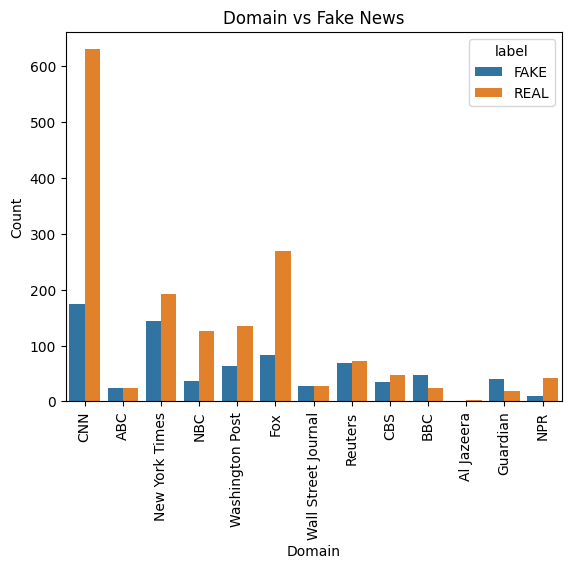

In [ ]:
known_source = df[df['source'] != 'Unknown']

#Plot a stacked bar chart to check the relationship between Fake news and sources
sns. countplot(data= known_source, x= 'source', hue='label')
plt.title('Domain vs Fake News')
plt.xlabel('Domain')
plt.ylabel('Count')
plt.legend(title='label')
plt.xticks(rotation=90)
plt.show()

From the chart above BBC and Guardian has a proportion of fake more than the real news.

##**Sentiment Score**

A sentiment score is a numerical measure of the emotional tone expressed in text, typically ranging from -1 (very negative) to +1 (very positive), with values near 0 indicating neutrality. It is commonly derived using natural language processing techniques and provides a way to quantify subjective opinions, emotions, or attitudes in written content. Sentiment scores are widely used in tasks like opinion mining, social media analysis, and fake news detection to understand whether a piece of text conveys negativity, positivity, or remains neutral.

In [ ]:
#Import Necessary Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


title  \
0                     You Can Smell Hillary‚Äôs Fear   
1  Watch The Exact Moment Paul Ryan Committed Pol...   
2        Kerry to go to Paris in gesture of sympathy   
3  Bernie supporters on Twitter erupt in anger ag...   
4   The Battle of New York: Why This Primary Matters   

                                                text label          source  \
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE             CNN   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE             ABC   
2  U.S. Secretary of State John F. Kerry said Mon...  REAL         Unknown   
3  ‚Äî Kaydee King (@KaydeeKing) November 9, 2016...  FAKE  New York Times   
4  It's primary day in New York and front-runners...  REAL         Unknown   

   sentiment_score  
0          -0.9994  
1           0.7723  
2           0.9595  
3          -0.4242  
4           0.9903

###**Relationship between sentiment score and fake news**

Checking the relationship between fake and real news with sentiment is important because sentiment can reveal differences in writing style and intent. Fake news often relies on extreme emotional tones to provoke reactions, while real news tends to maintain a more neutral or balanced tone. By analyzing sentiment, we can identify these patterns and use them as features to better distinguish between fake and real content.

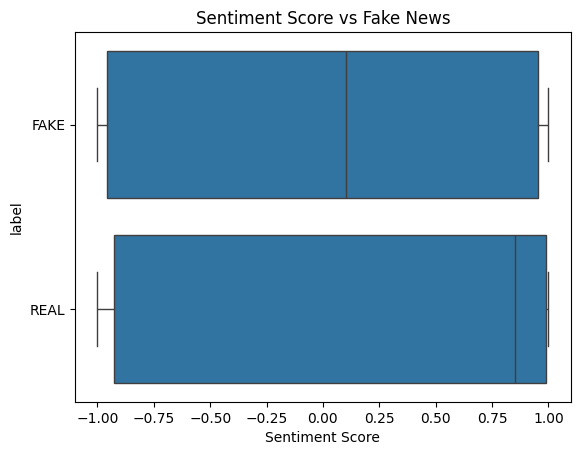

In [ ]:
#Plot a box plot to check the relation ship between sentiment score and fake news
sns.boxplot(data=df, x='sentiment_score', y='label')
plt.title('Sentiment Score vs Fake News')
plt.xlabel('Sentiment Score')
plt.ylabel('label')
plt.show()

The boxplot shows that fake news has a wide spread of sentiment scores, ranging from strongly negative to strongly positive, with the median near neutral. This suggests fake news often uses emotionally charged language — fear, anger, or exaggerated praise — to capture attention and manipulate readers, which explains the greater variability.

Real news, on the other hand, is more clustered toward neutral to slightly positive sentiment, with a higher median. This could be because real reporting aims for factual balance and credibility, avoiding extreme emotional tone. The difference likely reflects the intent: fake news seeks to provoke strong reactions, while real news prioritizes informative, measured communication.

In [ ]:
!pip install wordcloud #Install word cloud to be able to plot the most frequent words in a word cloud

##**Plotting word cloud**

A word cloud plot is a visual representation of the most frequent words in a text dataset, where the size of each word reflects its frequency or importance. It provides a quick and intuitive way to identify dominant themes, keywords, or patterns within the text. In the context of fake news detection, separate word clouds for fake and real news can highlight differences in language use, showing which words are commonly associated with each category and offering insights into stylistic or thematic distinctions.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


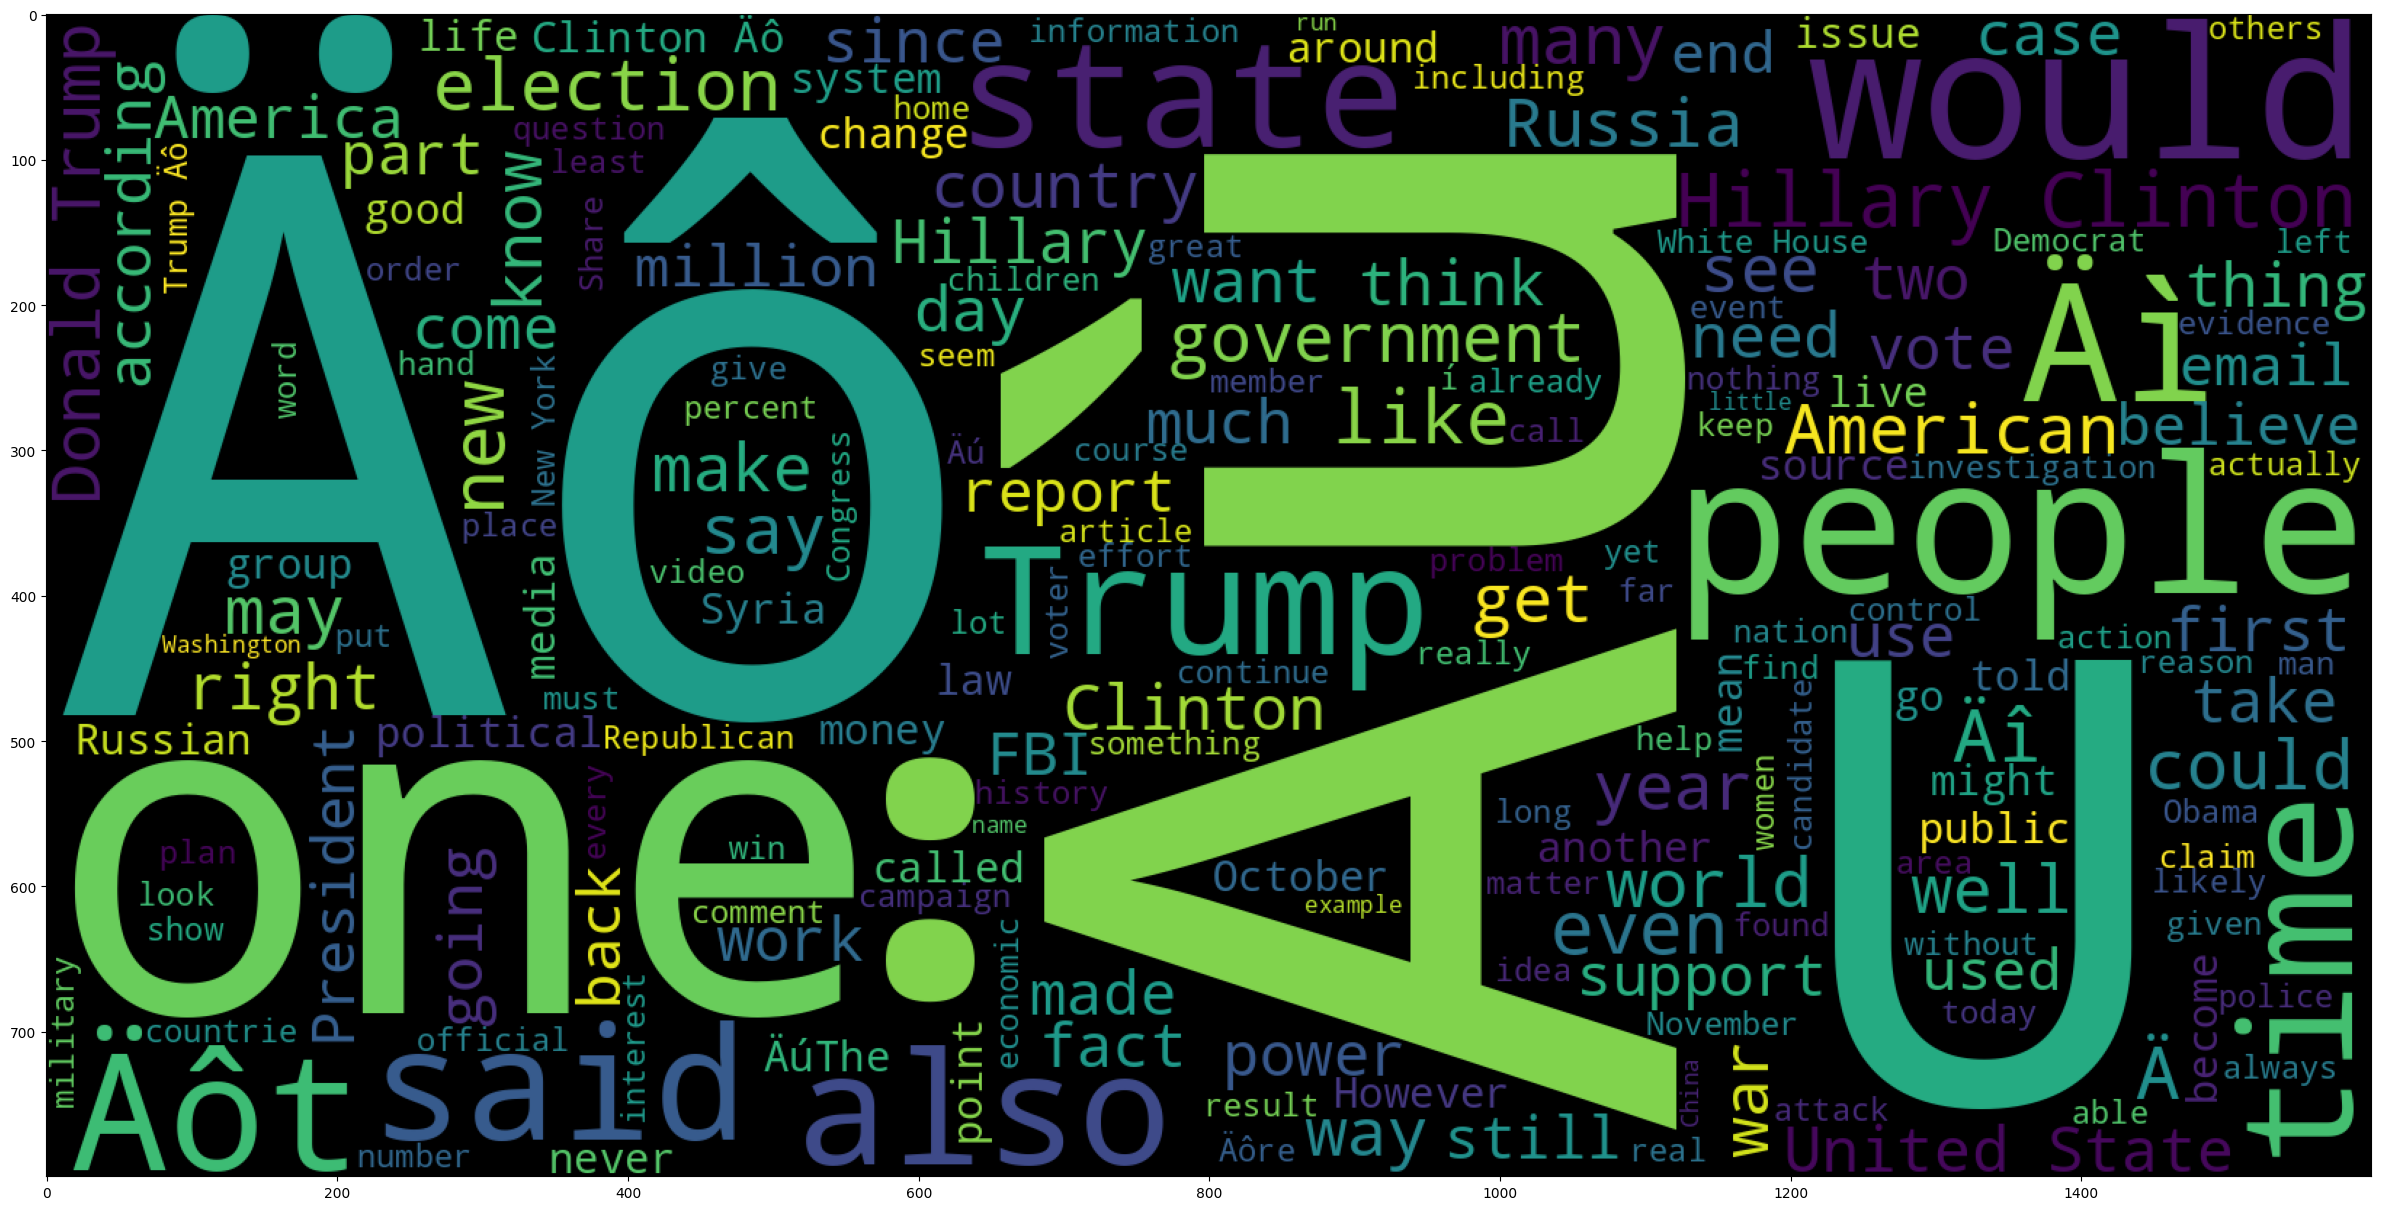

In [ ]:
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

text = " ".join(df.loc[df['label']=='FAKE', 'text'])

word_cloud = WordCloud(stopwords=stopwords.words('english'),
                       background_color='black',
                       width=1600,
                       height=800).generate(text)

plt.figure(1, figsize=(30,20))
plt.imshow(word_cloud)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


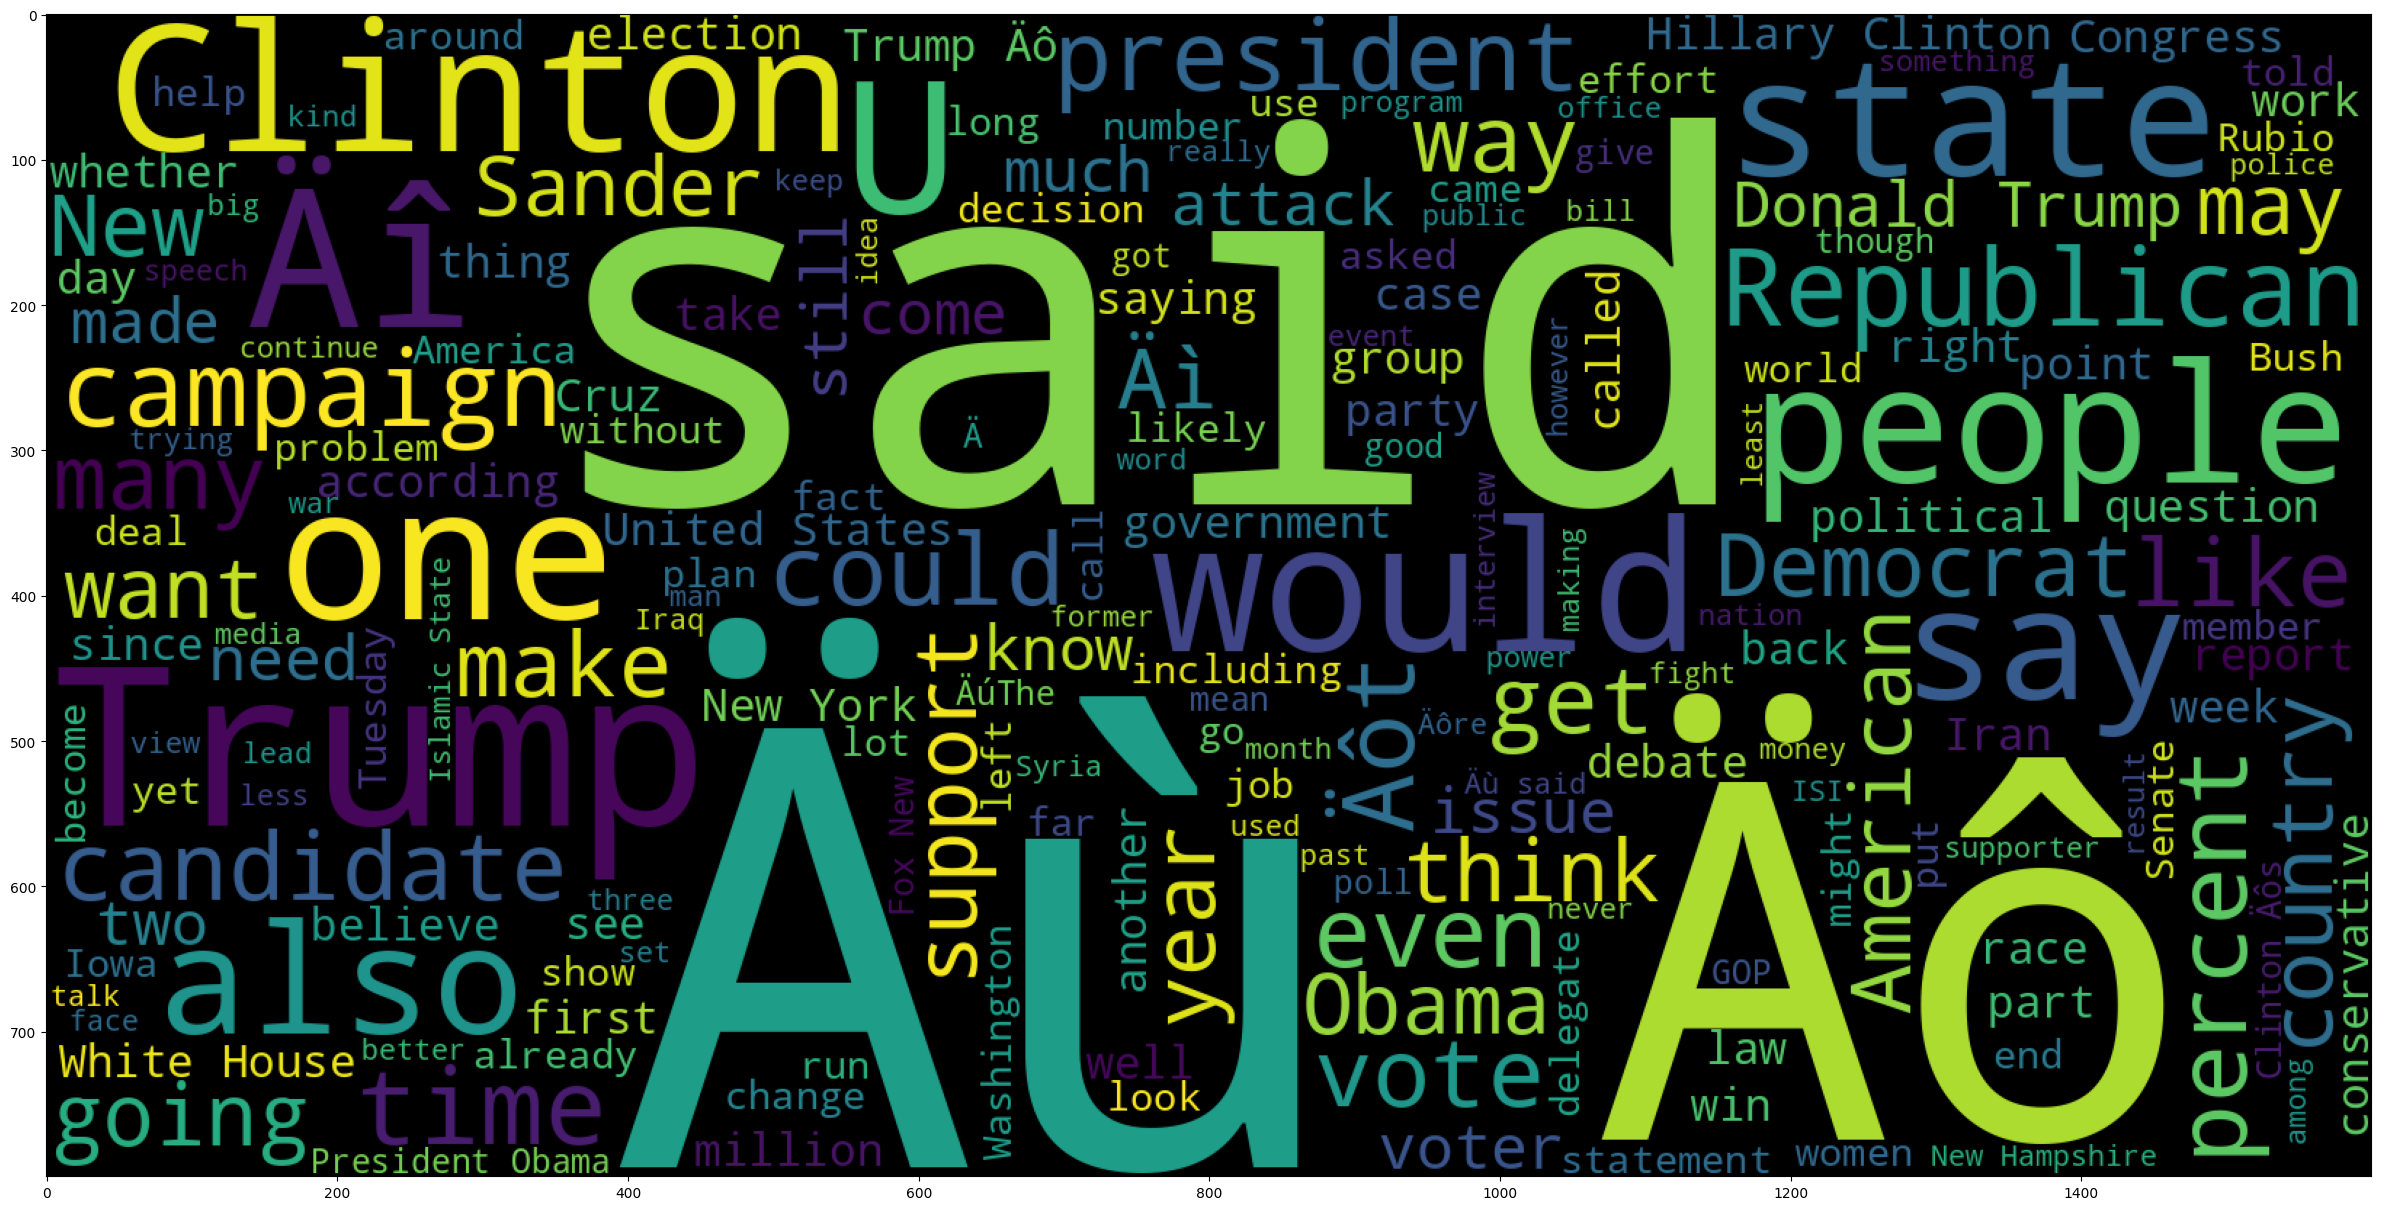

In [ ]:
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

text = " ".join(df.loc[df['label']=='REAL', 'text'])

word_cloud = WordCloud(stopwords=stopwords.words('english'),
                       background_color='black',
                       width=1600,
                       height=800).generate(text)

plt.figure(1, figsize=(30,20))
plt.imshow(word_cloud)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


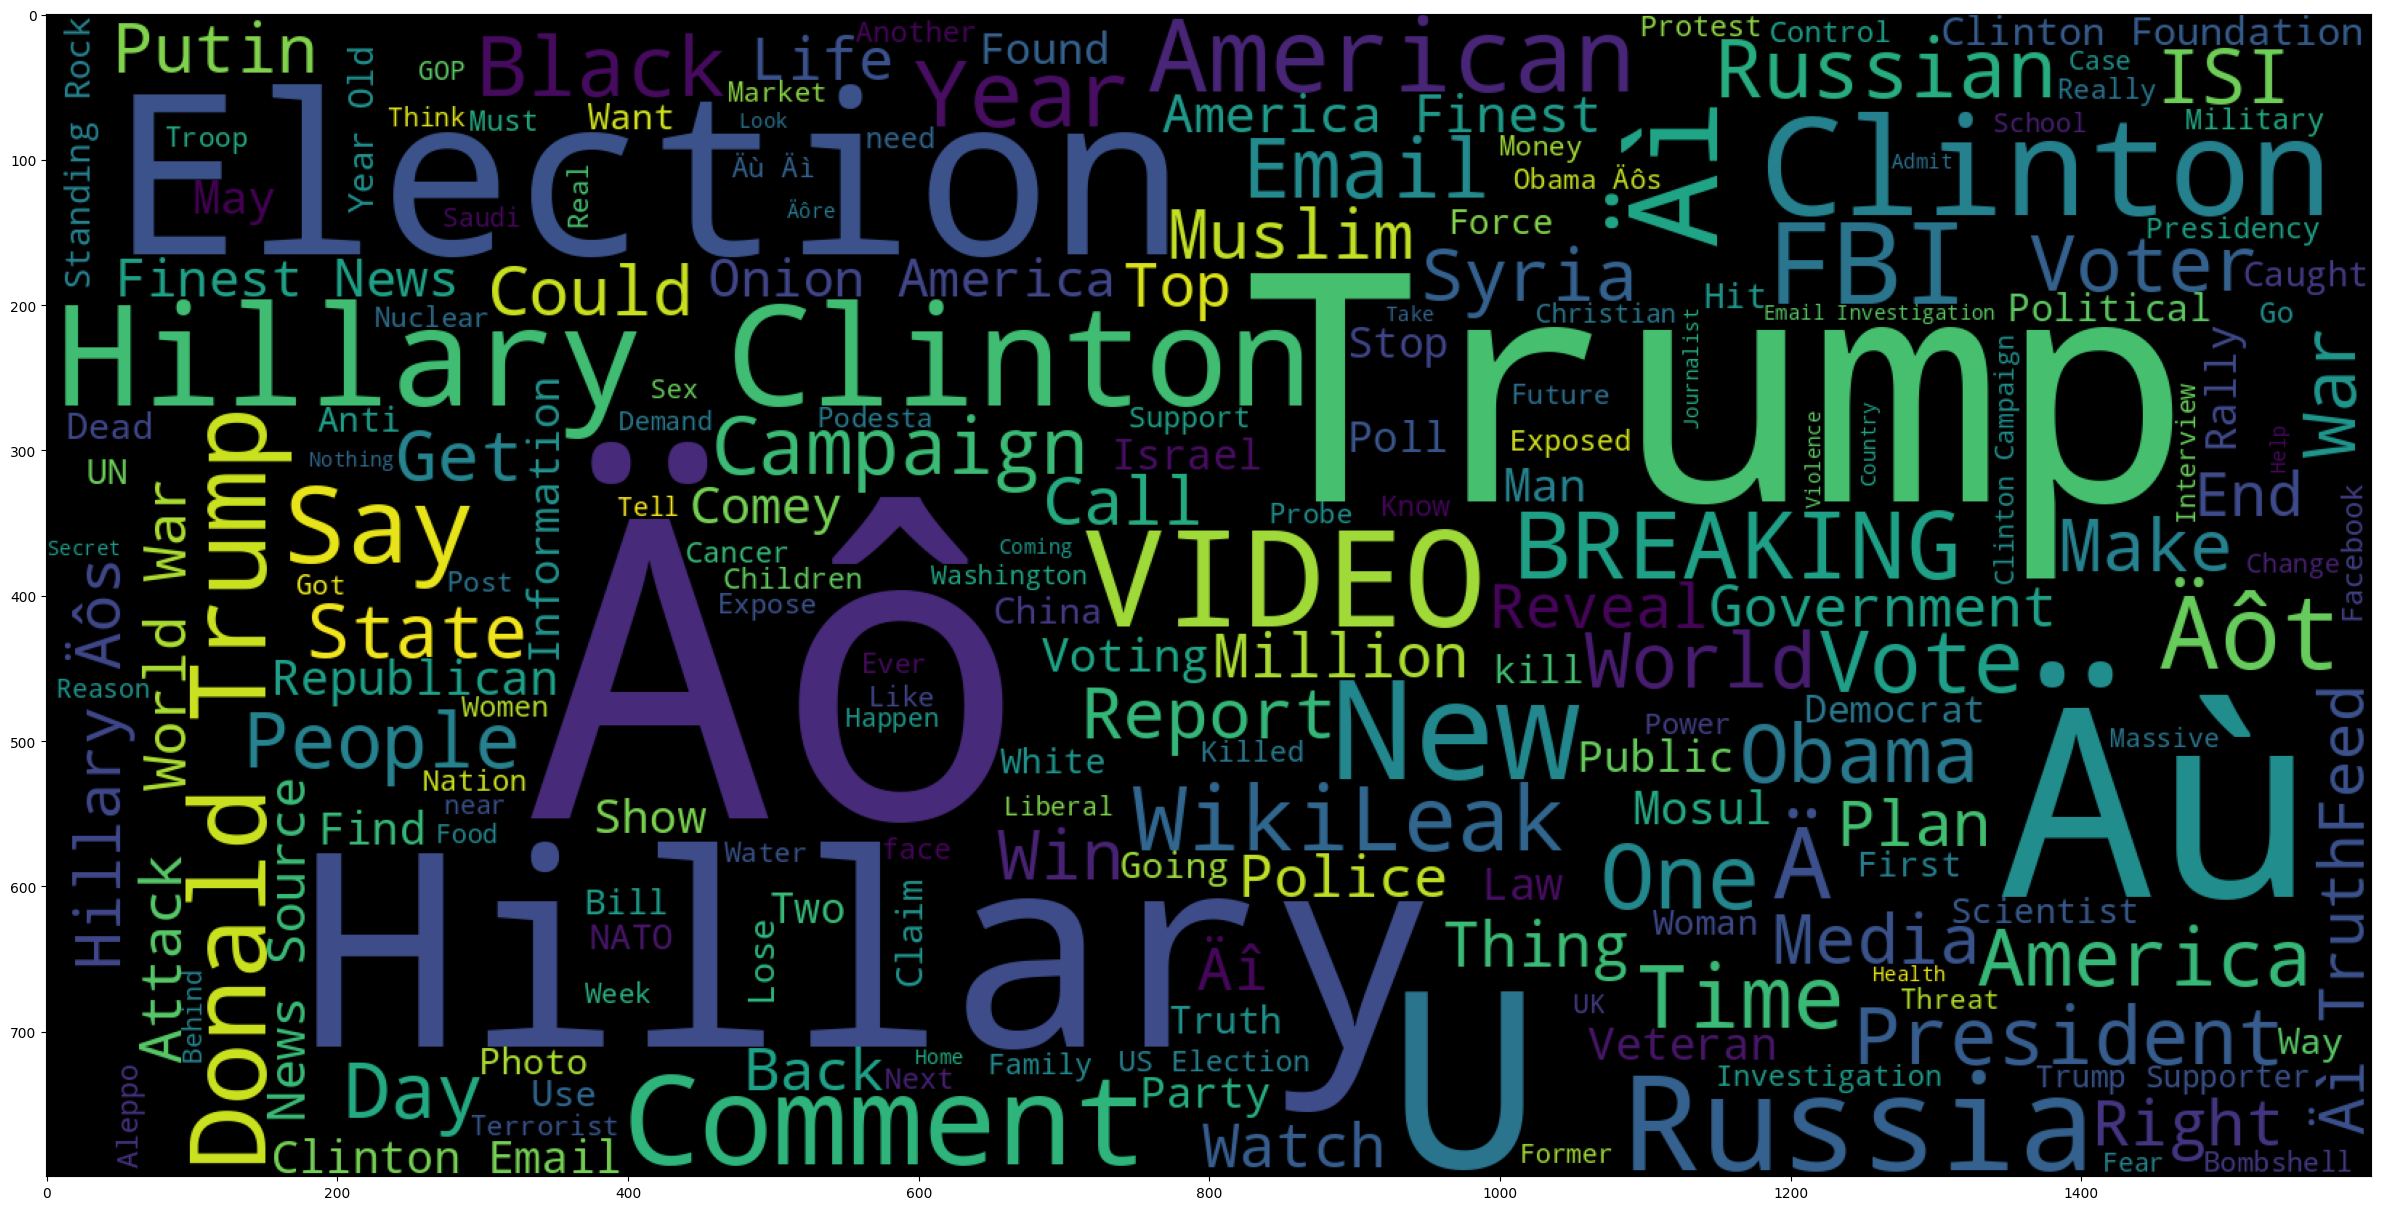

In [ ]:
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

text = " ".join(df.loc[df['label']=='FAKE', 'title'])

word_cloud = WordCloud(stopwords=stopwords.words('english'),
                       background_color='black',
                       width=1600,
                       height=800).generate(text)

plt.figure(1, figsize=(30,20))
plt.imshow(word_cloud)
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


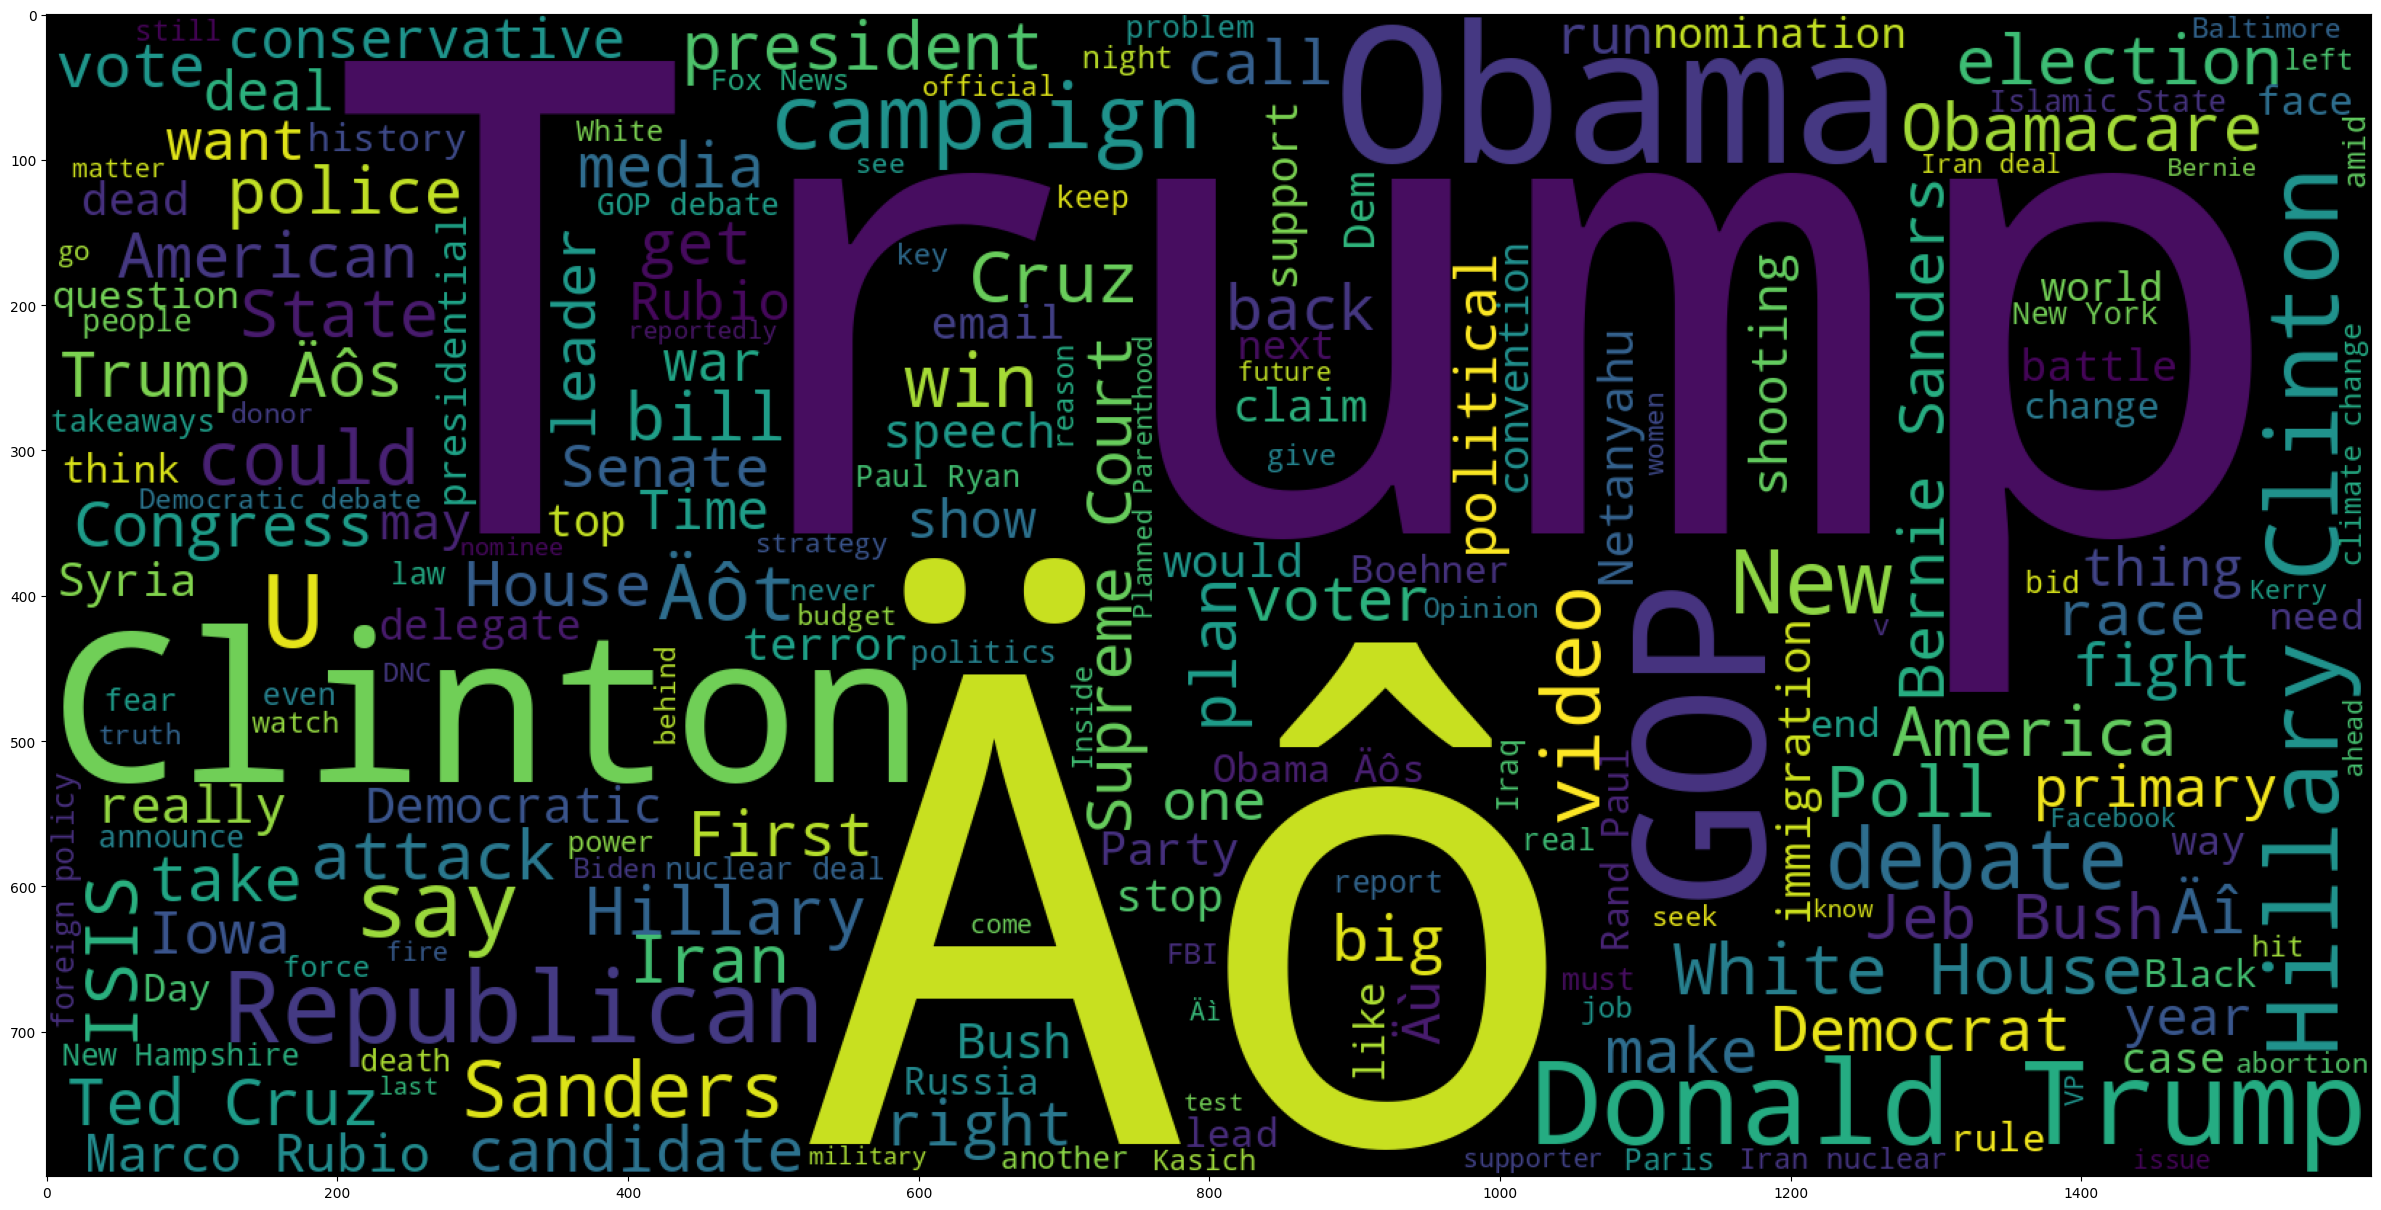

In [ ]:
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

text = " ".join(df.loc[df['label']=='REAL', 'title'])

word_cloud = WordCloud(stopwords=stopwords.words('english'),
                       background_color='black',
                       width=1600,
                       height=800).generate(text)

plt.figure(1, figsize=(30,20))
plt.imshow(word_cloud)
plt.show()

##**Model Development**

In [ ]:
#Split data in to X and y
X = df.drop(columns=['label'])
y = df['label']

X,y

(                                                  title  \
 0                        You Can Smell Hillary‚Äôs Fear   
 1     Watch The Exact Moment Paul Ryan Committed Pol...   
 2           Kerry to go to Paris in gesture of sympathy   
 3     Bernie supporters on Twitter erupt in anger ag...   
 4      The Battle of New York: Why This Primary Matters   
 ...                                                 ...   
 6330  State Department says it can't find emails fro...   
 6331  The ‚ÄòP‚Äô in PBS Should Stand for ‚ÄòPlutocr...   
 6332  Anti-Trump Protesters Are Tools of the Oligarc...   
 6333  In Ethiopia, Obama seeks progress on peace, se...   
 6334  Jeb Bush Is Suddenly Attacking Trump. Here's W...   
 
                                                    text           source  \
 0     Daniel Greenfield, a Shillman Journalism Fello...              CNN   
 1     Google Pinterest Digg Linkedin Reddit Stumbleu...              ABC   
 2     U.S. Secretary of State John F. Kerry sa

In [ ]:
#Split data into X_train, X_test, y_train, and y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

title  \
1955  Complete the Sentence: an Exploration of Orin ...   
2356  Tens of Thousands of People Just Got Fooled By...   
3985  Comment on After Sweeping Election, First Thin...   
3292  This astonishing chart shows how moderate Repu...   
5708       Clinton ekes out win in Iowa against Sanders   

                                                   text          source  \
1955  Email \nTo view photojournalist Orin Langelle‚...         Unknown   
2356  Pinterest \nThere have been plenty of stories ...         Unknown   
3985  Dispatches from Wolf Country ‚ÄìSitting in my ...         Unknown   
3292  Political scientists have known for years that...  New York Times   
5708  Killing Obama administration rules, dismantlin...         Unknown   

      sentiment_score  
1955          -0.9843  
2356          -0.9585  
3985           0.9977  
3292           0.9568  
5708          -0.6597

### Text Preprocessing

In [ ]:
#Import Necessary library for preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Initialize the lemnatizer and stemmer
stemmer = PorterStemmer() #Initiate the stemmer
lemmatizer = WordNetLemmatizer() #Initiate the lemmatizer

In [ ]:
def preprocess(raw_text, flag):
  #remove special characters and digits
  sentence = re.sub("[^a-zA-Z]", " ", raw_text)

  #Change sentence to lower case
  sentence = sentence.lower()

  #Tokenize into words
  tokens = sentence.split()

  #Remove stopwords
  clean_tokens = [t for t in tokens if not t in stopwords.words('english')]

  #Stemming/Lemmatization
  if (flag =='stem'):
    clean_tokens = [stemmer.stem(word) for word in clean_tokens]
  else:
    clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]

  return pd.Series([" ".join(clean_tokens), len(clean_tokens)])

### **Applying the function above to X_train data**

I applied a custom preprocessing function to clean the X_train data by removing special characters, converting to lowercase, tokenizing, removing stopwords, and performing lemmatization. I chose lemmatization because it reduces words to their base or dictionary form (e.g., running → run) while preserving meaning better than stemming, which often cuts words too aggressively. This ensures a cleaner, more semantically accurate representation of the text for analysis.

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

temp_df_title = X_train['title'].progress_apply(lambda x: preprocess(x, 'lemma'))
temp_df_text = X_train['text'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df = pd.concat([temp_df_title, temp_df_text], axis=1)

temp_df.head()

100%|██████████| 5039/5039 [06:38<00:00, 12.66it/s]


0   1  \
1955  complete sentence exploration orin langelle vo...   8   
2356  ten thousand people got fooled fake ballot wit...  10   
3985  comment sweeping election first thing trump in...  12   
3292  astonishing chart show moderate republican end...   7   
5708                       clinton ekes win iowa sander   5   

                                                      0    1  
1955  email view photojournalist orin langelle new o...  643  
2356  pinterest plenty story voter fraud across coun...  278  
3985  dispatch wolf country sitting cave watching sp...  255  
3292  political scientist known year political polar...  250  
5708  killing obama administration rule dismantling ...   11

In [ ]:
temp_df.columns = ['clean_title', 'clean_title_wc', 'clean_text', 'clean_text_wc'] #Rename the columns
X_train = pd.concat([X_train, temp_df], axis=1)

X_train.head()

title  \
1955  Complete the Sentence: an Exploration of Orin ...   
2356  Tens of Thousands of People Just Got Fooled By...   
3985  Comment on After Sweeping Election, First Thin...   
3292  This astonishing chart shows how moderate Repu...   
5708       Clinton ekes out win in Iowa against Sanders   

                                                   text          source  \
1955  Email \nTo view photojournalist Orin Langelle‚...         Unknown   
2356  Pinterest \nThere have been plenty of stories ...         Unknown   
3985  Dispatches from Wolf Country ‚ÄìSitting in my ...         Unknown   
3292  Political scientists have known for years that...  New York Times   
5708  Killing Obama administration rules, dismantlin...         Unknown   

      sentiment_score                                        clean_title  \
1955          -0.9843  complete sentence exploration orin langelle vo...   
2356          -0.9585  ten thousand people got fooled fake ballot wit...   
3985           0.9977  comment sweeping election first thing trump in...   
3292           0.9568  astonishing chart show moderate republican end...   
5708          -0.6597                       clinton ekes win iowa sander   

      clean_title_wc                                         clean_text  \
1955               8  email view photojournalist orin langelle new o...   
2356              10  pinterest plenty story voter fraud across coun...   
3985              12  dispatch wolf country sitting cave watching sp...   
3292               7  political scientist known year political polar...   
5708               5  killing obama administration rule dismantling ...   

      clean_text_wc  
1955            643  
2356            278  
3985            255  
3292            250  
5708             11

### BOW Representation of the X_train data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vocab = CountVectorizer()
X_train_bow = vocab.fit_transform(X_train['clean_title'] + " " + X_train['clean_text'])
X_train_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1355198 stored elements and shape (5039, 52901)>

In [ ]:
print('Total unique words: ', len(vocab.vocabulary_))
print('Type of train feature: ', type(X_train_bow))
print('Shape of input data: ', X_train_bow.shape)

Total unique words:  52901
Type of train feature:  <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data:  (5039, 52901)


## **Applying the function above to X_test data**

I applied a custom preprocessing function to clean the X_test data by removing special characters, converting to lowercase, tokenizing, removing stopwords, and performing lemmatization. I chose lemmatization because it reduces words to their base or dictionary form (e.g., running → run) while preserving meaning better than stemming, which often cuts words too aggressively. This ensures a cleaner, more semantically accurate representation of the text for analysis.

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

temp_df_title_test = X_test['title'].progress_apply(lambda x: preprocess(x, 'lemma'))
temp_df_text_test = X_test['text'].progress_apply(lambda x: preprocess(x, 'lemma'))

temp_df_test = pd.concat([temp_df_title_test, temp_df_text_test], axis=1)

temp_df_test.head()

100%|██████████| 1260/1260 [01:38<00:00, 12.74it/s]


0  1  \
3926                              way pick vps terrible  4   
3159                                  obama africa move  3   
5357  trump vega phoenix illegals wreaking havoc pop...  7   
3824  obama rare parliamentary window make recess ap...  9   
999             climate engineering cryosphere collapse  4   

                                                      0    1  
3926  mike penny tim kaine take stage vice president...  867  
3159  nairobi president obama praised kenya saturday...  851  
5357  republican presidential hopeful donald trump c...  764  
3824  much hubbub late president obama made four rec...  314  
999   geoengineeringwatch org global climate enginee...  505

In [ ]:
temp_df_test.columns = ['clean_title', 'clean_title_wc', 'clean_text', 'clean_text_wc'] #Rename the columns
X_test = pd.concat([X_test, temp_df_test], axis=1)

X_test.head()

title  \
3926            Why the way we pick our VPs is terrible   
3159                 Obama: ‚ÄòAfrica is on the move‚Äô   
5357  Trump in Vegas, Phoenix: Illegals 'Wreaking Ha...   
3824  Obama has rare parliamentary window to make re...   
999         Climate Engineering And Cryosphere Collapse   

                                                   text          source  \
3926  Mike Pence and Tim Kaine will take the stage f...  New York Times   
3159  NAIROBI ‚ÄîPresident Obama praised Kenya Satur...         Unknown   
5357  Republican presidential hopeful Donald Trump c...             CNN   
3824  There was much hubbub in late 2012 when Presid...         Unknown   
999   geoengineeringwatch.org \nGlobal climate engin...         Unknown   

      sentiment_score                                        clean_title  \
3926           0.9962                              way pick vps terrible   
3159           0.9973                                  obama africa move   
5357          -0.9929  trump vega phoenix illegals wreaking havoc pop...   
3824           0.9934  obama rare parliamentary window make recess ap...   
999           -0.9895            climate engineering cryosphere collapse   

      clean_title_wc                                         clean_text  \
3926               4  mike penny tim kaine take stage vice president...   
3159               3  nairobi president obama praised kenya saturday...   
5357               7  republican presidential hopeful donald trump c...   
3824               9  much hubbub late president obama made four rec...   
999                4  geoengineeringwatch org global climate enginee...   

      clean_text_wc  
3926            867  
3159            851  
5357            764  
3824            314  
999             505

### BOW Representation of X_test data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X_test_bow = vocab.transform(X_test['clean_title'] + " " + X_test['clean_text'])
X_test_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 337517 stored elements and shape (1260, 52901)>

In [ ]:
print('Total unique words: ', len(vocab.vocabulary_))
print('Type of train feature: ', type(X_test_bow))
print('Shape of input data: ', X_test_bow.shape)

##**Using Naive Bayes Model**

In [ ]:
%%time

#Import necessary libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

classifier = MultinomialNB()
classifier.fit(X_train_bow, y_train)

y_test_pred = classifier.predict(X_test_bow)

accuracy_score = metrics.accuracy_score(y_test, y_test_pred)

print('Accuracy Score = ', accuracy_score)

Accuracy Score =  0.9
CPU times: user 30.6 ms, sys: 0 ns, total: 30.6 ms
Wall time: 30.7 ms


Performance of NB Model

In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        FAKE       0.93      0.86      0.90       625
        REAL       0.87      0.94      0.90       635

    accuracy                           0.90      1260
   macro avg       0.90      0.90      0.90      1260
weighted avg       0.90      0.90      0.90      1260



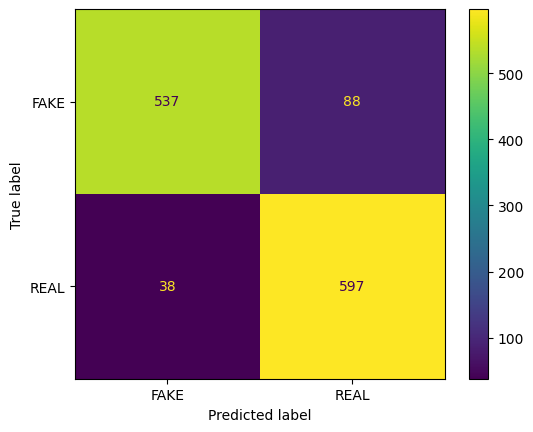

In [ ]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = classifier.classes_)
fig = metrics.ConfusionMatrixDisplay(cm, display_labels=classifier.classes_)
fig.plot()

The model demonstrated strong performance with an overall accuracy of 90%, supported by balanced F1-scores of 90 for both fake and real news. In terms of predictions, it correctly identified 537 fake news articles while misclassifying 38, and it accurately detected 597 real news articles with 88 misclassifications. The computation was also efficient, with a CPU time of 30.6 ms and a wall time of 30.7 ms, making the model both reliable and fast for distinguishing between fake and real news.

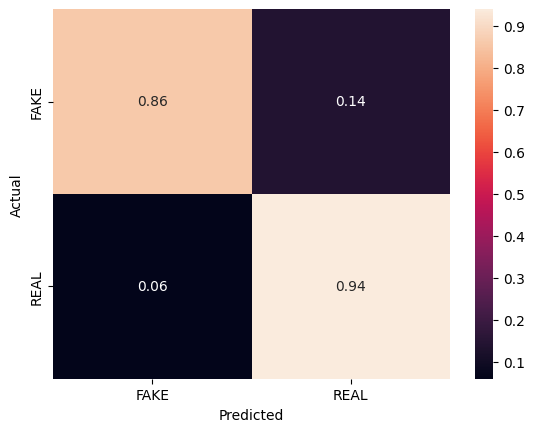

In [ ]:
actual = np.sum(cm, axis=1).reshape(-1,1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**What the Chart Represents**

a. Axes:

- The rows represent the actual classes (ground truth labels).
- The columns represent the predicted classes (output from the classification model).
b. Diagonal Cells:

The diagonal cells (top-left to bottom-right) indicate the proportion of correct predictions for each class. For example, the model correctly predicted:

86% of fake.
94% of Real.
c. Off-Diagonal Cells:

The off-diagonal cells indicate the proportion of misclassifications (where the model predicted the wrong class).

14% of fakes were misclassified as real.
6% of real samples were misclassified as fake

##**Using Logistic Regression**

In [ ]:
%%time

#Import Necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

LG_regressor = LogisticRegression() #Initiate the algorithm
LG_regressor.fit(X_train_bow, y_train) #Train the algorithm

y_test_pred = LG_regressor.predict(X_test_bow) #Predicting burn_rate

accuracy_score = metrics.accuracy_score(y_test, y_test_pred)


print('Accuracy Score = ', accuracy_score)

Accuracy Score =  0.9285714285714286
CPU times: user 5.17 s, sys: 26.1 ms, total: 5.2 s
Wall time: 2.76 s


In [ ]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

        FAKE       0.93      0.92      0.93       625
        REAL       0.92      0.94      0.93       635

    accuracy                           0.93      1260
   macro avg       0.93      0.93      0.93      1260
weighted avg       0.93      0.93      0.93      1260



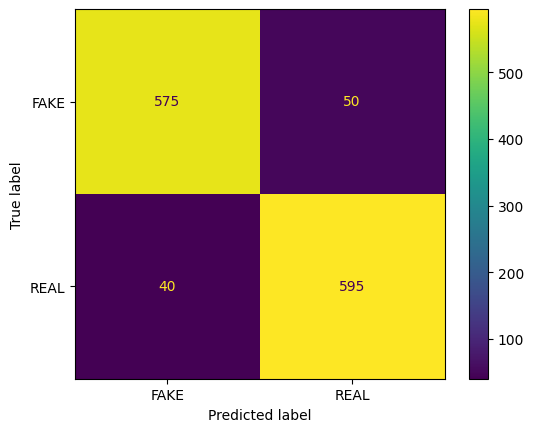

In [ ]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = classifier.classes_)
fig = metrics.ConfusionMatrixDisplay(cm, display_labels=classifier.classes_)
fig.plot()

The logistic regression model achieved an impressive accuracy of 93%, with balanced F1-scores of 93% for both fake and real news, showing consistent performance across classes. Although it required more computation time compared to other models (CPU time: 5.2s, wall time: 2.76s), the high accuracy and balanced F1-scores highlight its effectiveness in reliably distinguishing between fake and real news.

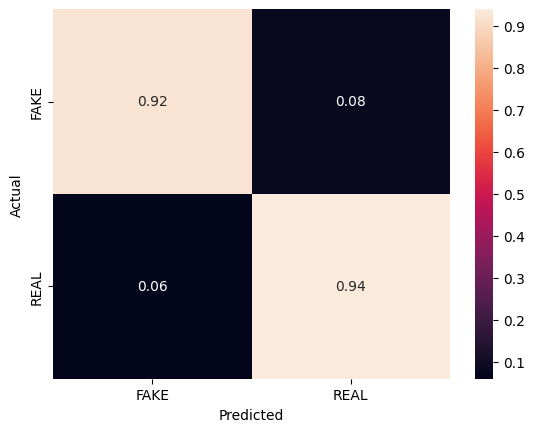

In [ ]:
actual = np.sum(cm, axis=1).reshape(-1,1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**What the Chart Represents**

a. Axes:

The rows represent the actual classes (ground truth labels).
The columns represent the predicted classes (output from the classification model).

b. Diagonal Cells:

The diagonal cells (top-left to bottom-right) indicate the proportion of correct predictions for each class. For example, the model correctly predicted:

92% of fake.

94% of Real.

c. Off-Diagonal Cells:

The off-diagonal cells indicate the proportion of misclassifications (where the model predicted the wrong class).

8% of fakes were misclassified as real. 6% of real samples were misclassified as fake

## **Naive Bayes Model**

**Strengths:** Very fast and computationally efficient, with CPU and wall times under 31 ms. It delivers good performance with 90% accuracy and balanced F1-scores of 90% for both fake and real news. This makes it suitable for large-scale or real-time applications where speed is critical.

**Weaknesses:** Slightly less accurate compared to logistic regression, meaning it may misclassify more articles, especially when subtle linguistic patterns are important.

## **Logistic Regression Model**

**Strengths:** Achieved higher accuracy (93%) and F1-scores (93% for both classes), showing stronger predictive performance and better handling of distinguishing patterns between fake and real news. This makes it more reliable when accuracy is the top priority.

**Weaknesses:** Computationally more expensive, requiring 5.2s CPU time and 2.76s wall time, which may be limiting for very large datasets or time-sensitive tasks.

**Logistic regression is the better choice for accuracy and reliability, while Naive Bayes is preferred for speed and efficiency.**

## **Summary of Key Insights**

The dataset is well balanced between fake (3,128) and real (3,171) news, which is ideal for fair model training and evaluation. Attempts to extract domains from text using regex and keyword matching revealed a limitation — over 3,900 articles had unknown sources since many titles and texts did not explicitly mention publishers. This restricts deeper source-level analysis, though among identified sources, outlets like BBC and The Guardian showed a higher share of fake news compared to real.

Sentiment analysis showed a clear difference in tone: fake news had a wider spread, often leaning toward emotionally charged language, while real news clustered near neutral to slightly positive sentiment, reflecting its more factual and balanced style. On the modeling side, both Naive Bayes and Logistic Regression performed well. Naive Bayes achieved 90% accuracy with very fast runtime, while Logistic Regression achieved higher accuracy (93%) and balanced F1-scores, though at the cost of slower computation. Confusion matrices revealed that fake news was more prone to being misclassified as real compared to the reverse, aligning with the idea that deceptive articles sometimes mimic the style of genuine reporting.

**Ethical Considerations**

**Bias and Fairness:** Models may unintentionally learn biases from training data, leading to unfairly labeling legitimate sources as fake. Regular audits and diverse datasets are needed.

**Improvements & Additional Features**

**Linguistic Features**: Incorporate advanced NLP features such as writing style, subjectivity, readability scores, and use of sensationalist keywords.

**Metadata Features:** Expand beyond text to include time of publication, author consistency, and frequency of posting.

**Network Analysis:** Examine how news spreads on social media — fake news often has distinctive sharing patterns.